In [ ]:
from typing import TypedDict,Annotated,Sequence
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage,AIMessage,ToolMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph,END
from langgraph.prebuilt import ToolNode


In [ ]:
!pip install -U langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
from langchain_groq import ChatGroq

In [ ]:
load_dotenv()

False

In [ ]:
document_content=""

In [ ]:
class AgentState(TypedDict):
  messages:Annotated[Sequence[BaseMessage],add_messages]

In [ ]:
@tool
def update(content:str)->str:
  """Updates the document with the provided content"""
  global document_content
  document_content=content
  return f"Document has been updates successfully! The current document is:\n{document_content}"


In [ ]:
@tool
def save(filename:str)->str:
  """Saves the current document to a text file and finish the process.

  Args:
       filename:Name for the text file.
  """
  if not filename.endswith('.txt'):
    filename=f"{filename}.txt"

  try:
    with open(filename,'w') as file:
      file.write(document_content)
    print(f"\n Document has been saved to{filename}")
    return f"Document has been saved successfully to'{filename}'."
  except Exception as e:
    return f"Error saving document:{str(e)}"



In [ ]:
tools=[update,save]

In [ ]:
llm=ChatGroq(model="llama-3.3-70b-versatile",
             api_key="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",
             temperature=0
             )
model=llm.bind_tools(tools)

In [ ]:
def our_agent(state:AgentState)->AgentState:
  system_prompt=SystemMessage(content=f"""You are Drafter, a helpful writing assistant. You are going to help the user update and

- If the user wants to update or modify content, use the 'update' tool with the complete
- If the user wants to save and finish, you need to use the 'save' tool.
- Make sure to always show the current document state after modifications.

The current document content is:{document_content}"""
)


  if not state["messages"]:
    user_input=input("I'm ready to help you update a document.What would you like the document?")
    print(f"\n USER:{user_input}")
    user_message=HumanMessage(content=user_input)
  else:
    user_input=input("\nWhat would you like to do with the document?")
    print(f"\n USER:{user_input}")
    user_message=HumanMessage(content=user_input)
  all_messages=[system_prompt]+list(state["messages"])+[user_message]
  response=model.invoke(all_messages)
  print(f"AI:{response.content}")
  if hasattr(response,"tool_calls")and response.tool_calls:
    print(f"USING TOOLS:{[tc['name'] for tc in response.tool_calls]}")
  return {"messages":list(state["messages"])+[user_message,response]}


In [ ]:
def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation"""
    messages = state["messages"]
    if not messages:
        return "continue"

    for message in reversed(messages):
        if (isinstance(message, ToolMessage) and
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end"

    return "continue"  # Add this line - default return if loop completes

In [ ]:
graph=StateGraph(AgentState)
graph.add_node("our_agent",our_agent)
graph.add_node("tools",ToolNode(tools))
graph.add_edge("our_agent","tools")
graph.set_entry_point("our_agent")
graph.add_conditional_edges("tools",should_continue,{
    "continue":"our_agent",
    "end":END
})
app=graph.compile()


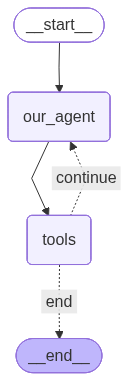

In [ ]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))


In [ ]:

def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠 TOOL RESULT: {message.content}")

app = graph.compile()

def run_document_agent():
    print("\n ===== DRAFTER =====")

    state = {"messages": []}

    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])

    print("\n ===== DRAFTER FINISHED =====")

if __name__ == "__main__":
    run_document_agent()



 ===== DRAFTER =====
I'm ready to help you update a document.What would you like the document?write an email to peeyush as he is disobidient with girls in uni

 USER:write an email to peeyush as he is disobidient with girls in uni
AI:
USING TOOLS:['update']

🛠 TOOL RESULT: Document has been updates successfully! The current document is:
Subject: Concern about Behavior
Dear Peeyush,
I am writing to express concern about your behavior towards girls in the university. It has been reported that you have been disobedient and disrespectful towards them. As a student, it is essential to maintain a respectful and considerate attitude towards your peers, regardless of gender.
I would like to remind you that such behavior can create a hostile environment and may lead to serious consequences. I encourage you to reflect on your actions and make a conscious effort to change your behavior.
If you have any questions or concerns, please do not hesitate to reach out to me.
Best regards,

What would yo